In [25]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [26]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [27]:
dfs = []
for i in range(1, 5):
    df_score = pd.read_csv(f"../data/news_risk_apple_2022_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/news_risk_apple_2022_all.csv")
df_score

(439, 3)
(1096, 3)
(1300, 3)
(4383, 3)


,date,score
0,2022-01-01 01:04:02,65
1,2022-01-03 08:39:46,65
2,2022-01-03 15:51:00,85
3,2022-01-04 05:59:38,85
4,2022-01-04 10:47:10,40
...,...,...
7213,2022-12-30 17:40:26,65
7214,2022-12-30 20:48:24,85
7215,2022-12-31 07:05:30,65
7216,2022-12-31 12:34:14,85


In [28]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [29]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [30]:
df_news.shape

(43832, 2)

In [31]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [32]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [33]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
114,2022-01-03 09:40:47,Thinking about trading options or stock in Nio...,177.969357,20.0,0.001332,-0.001443,0.006270,0.003828
115,2022-01-03 09:41:17,AirPods Pro 2 rumored to feature lossless audi...,178.087852,25.0,0.000222,-0.002329,0.004159,0.004269
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,178.349528,78.0,0.001966,0.001301,0.002575,0.002962
124,2022-01-03 10:26:39,Tech Payouts Can Propel Duo of Dividend ETFsTe...,178.591455,85.0,-0.000995,0.000332,0.001106,0.003870
125,2022-01-03 10:41:18,iPhone 14 tipped with hole-punch display along...,178.848194,75.0,0.000055,0.000000,-0.002761,0.001877
...,...,...,...,...,...,...,...,...
43645,2022-12-29 12:19:31,​U.S. stock rally gathers strength; Nasdaq 100...,129.46138,25.0,-0.000653,-0.001459,-0.005108,-0.004647
43655,2022-12-29 14:54:14,Peloton: The Problem Is The ProductPeloton is ...,129.053659,85.0,-0.000039,0.001194,0.000886,0.000963
43735,2022-12-30 10:07:00,Iridium: Assessing Benefits From A Potential S...,126.930526,85.0,0.001097,0.002507,0.006268,0.009715
43745,2022-12-30 11:45:31,NHL’s Bettman Has Plan to Keep Hockey a Big 4 ...,127.780773,87.0,0.001051,0.001440,0.003969,0.003152


In [34]:
result_df = result_df.dropna()

In [35]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_8449/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,2278,2278,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
unique,2275,2263,1978.000000,NaN,NaN,NaN,NaN,NaN
top,2022-12-08 13:46:51,"CVS, Apple, Target, and Ben & Jerry’s Top “Ski...",173.707338,NaN,NaN,NaN,NaN,NaN
freq,2,2,5.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:40:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-30 13:17:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,59.723881,0.000051,0.000063,-0.000040,-0.000129
std,NaN,NaN,NaN,25.721912,0.002009,0.002880,0.004638,0.006293
min,NaN,NaN,NaN,10.000000,-0.011893,-0.022818,-0.026805,-0.033490
25%,NaN,NaN,NaN,35.000000,-0.001038,-0.001479,-0.002439,-0.003458


In [36]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [37]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [38]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.022654,-0.005850,0.010105,0.016120
return_in5,-0.022654,1.000000,0.702505,0.409473,0.310364
return_in10,-0.005850,0.702505,1.000000,0.595205,0.450332
return_in20,0.010105,0.409473,0.595205,1.000000,0.723303
return_in60,0.016120,0.310364,0.450332,0.723303,1.000000


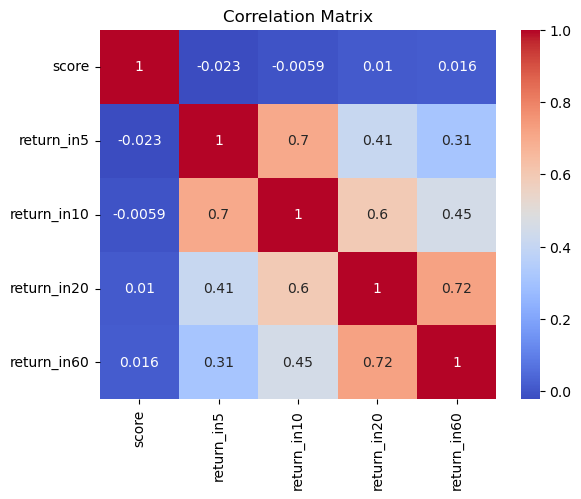

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

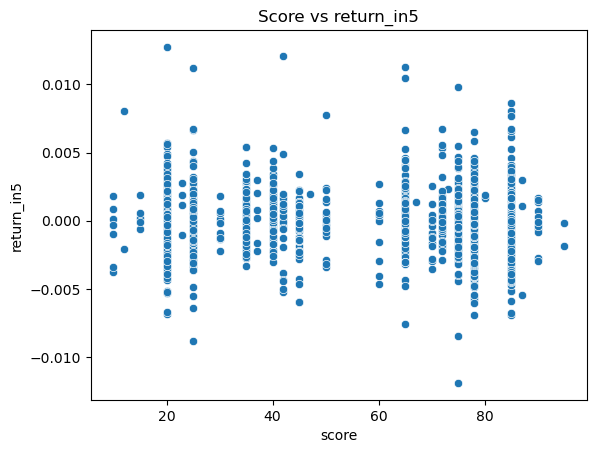

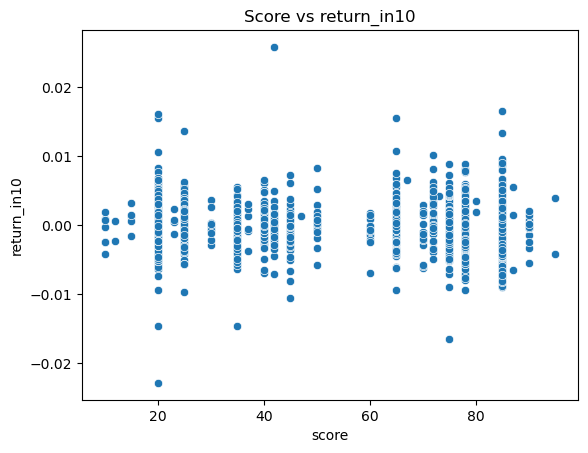

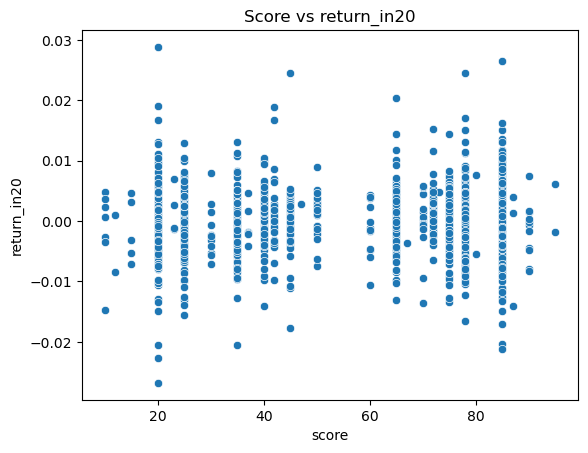

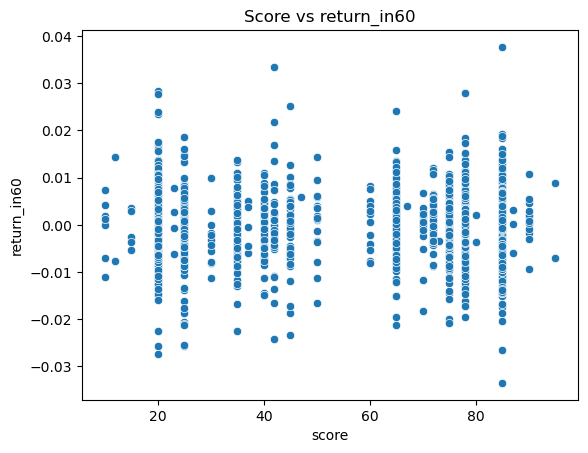

In [40]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [41]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(2278, 4)

In [42]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [43]:
X.shape

(2278, 1)

In [44]:
lr.coef_

array([[-1.76913378e-06],
       [-6.55124104e-07],
       [ 1.82201013e-06],
       [ 3.94362471e-06]])

In [57]:
result_df_fluc = result_df[abs(result_df["return_in60"]) > 0.02]

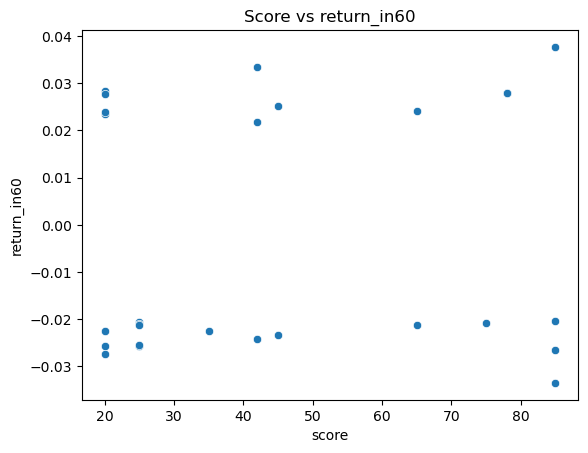

In [58]:
sns.scatterplot(x='score', y="return_in60", data=result_df_fluc)
plt.title(f'Score vs {"return_in60"}')
plt.show()

In [66]:
for i in range(result_df_fluc.shape[0]):
    score = result_df_fluc["score"].iloc[i]
    return_60 = result_df_fluc["return_in60"].iloc[i]
    news = result_df_fluc["news"].iloc[i]
    print(f"The score is {score} return is {return_60} \n news is {news}")

The score is 35.0 return is -0.022550831792976053 
 news is Android app public preview hits Windows 11 to bring ‘new era of the PC’Microsoft has just announced that it will soon release a much-anticipated update: Windows 11 will feature Android apps. This cooperation between Windows and Android marks a welcome change. Although…

The score is 20.0 return is -0.022550831792976053 
 news is Can Continued Services Growth Aid Apple's (AAPL) Q1 Earnings?Apple's (AAPL) first-quarter fiscal 2022 results are expected to reflect expanding Services business as well as solid Mac sales.

The score is 20.0 return is -0.025700791265411388 
 news is DGA Awards TV Noms: Five 'Succession' Episodes Vie For Dramatic Series; 'Ted Lasso' Leads ComediesIt’ll be a case of Succession-on-Succession violence at the 74th annual DGA Awards. The Directors Guild revealed its TV nominations today, and all five nominees for Dramatic Series are episod…

The score is 78.0 return is 0.02791346824842988 
 news is LIVE MAR

In [64]:
result_df_fluc["news"].iloc[0]

'Android app public preview hits Windows 11 to bring ‘new era of the PC’Microsoft has just announced that it will soon release a much-anticipated update: Windows 11 will feature Android apps. This cooperation between Windows and Android marks a welcome change. Although…\n'